In [1]:
pip install imageio


In [2]:
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from collections import deque
import gym

In [3]:
# Define the City Navigation Environment with Obstacles
class CityNavigationEnv(gym.Env):
    def __init__(self, grid_size=5, num_obstacles=3):
        super(CityNavigationEnv, self).__init__()
        self.grid_size = grid_size
        self.num_obstacles = num_obstacles
        self.state_size = grid_size * grid_size
        self.action_space = gym.spaces.Discrete(4)  # 4 actions: up, down, left, right
        self.observation_space = gym.spaces.Box(low=0, high=1, shape=(self.state_size,), dtype=np.float32)
        self.reset()

    def reset(self):
        self.agent_pos = [0, 0]  # Start at (0,0)
        self.goal_pos = [self.grid_size - 1, self.grid_size - 1]  # Goal at bottom-right
        self.obstacles = self._generate_obstacles()
        return self._get_state()

    def _generate_obstacles(self):
        obstacles = set()
        while len(obstacles) < self.num_obstacles:
            obs = (random.randint(0, self.grid_size - 1), random.randint(0, self.grid_size - 1))
            if obs != tuple(self.agent_pos) and obs != tuple(self.goal_pos):
                obstacles.add(obs)
        return list(obstacles)

    def step(self, action):
        x, y = self.agent_pos
        if action == 0 and x > 0 and (x - 1, y) not in self.obstacles:  # Up
            x -= 1
        elif action == 1 and x < self.grid_size - 1 and (x + 1, y) not in self.obstacles:  # Down
            x += 1
        elif action == 2 and y > 0 and (x, y - 1) not in self.obstacles:  # Left
            y -= 1
        elif action == 3 and y < self.grid_size - 1 and (x, y + 1) not in self.obstacles:  # Right
            y += 1
        
        self.agent_pos = [x, y]
        reward = 1 if self.agent_pos == self.goal_pos else -0.1
        done = self.agent_pos == self.goal_pos
        return self._get_state(), reward, done, {}

    def _get_state(self):
        state = np.zeros((self.grid_size, self.grid_size))
        state[self.agent_pos[0], self.agent_pos[1]] = 1
        state[self.goal_pos[0], self.goal_pos[1]] = 0.5
        for obs in self.obstacles:
            state[obs[0], obs[1]] = -1
        return state.flatten()


In [4]:
# Define the DQN Model
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, output_dim)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)


In [5]:
# Define the DQN Agent
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=1000)
        self.gamma = 0.95
        self.epsilon = 1.0  # Exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.batch_size = 32
        self.model = DQN(state_size, action_size)
        self.target_model = DQN(state_size, action_size)
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        self.update_target_network()

    def update_target_network(self):
        self.target_model.load_state_dict(self.model.state_dict())

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        state = torch.FloatTensor(state).unsqueeze(0)
        return torch.argmax(self.model(state)).item()

    def replay(self):
        if len(self.memory) < self.batch_size:
            return
        batch = random.sample(self.memory, self.batch_size)
        for state, action, reward, next_state, done in batch:
            target = self.model(torch.FloatTensor(state)).detach().clone()
            if done:
                target[action] = reward
            else:
                next_q_values = self.target_model(torch.FloatTensor(next_state)).detach()
                target[action] = reward + self.gamma * torch.max(next_q_values).item()
            
            self.optimizer.zero_grad()
            output = self.model(torch.FloatTensor(state))
            loss = F.mse_loss(output, target)
            loss.backward()
            self.optimizer.step()

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

In [6]:

# Train the DQN Agent
env = CityNavigationEnv(grid_size=5, num_obstacles=3)
state_size = env.state_size
action_size = env.action_space.n
agent = DQNAgent(state_size, action_size)

episode_rewards = []
num_episodes = 500
for episode in range(num_episodes):
    state = env.reset()
    total_reward = 0
    for t in range(100):
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward
        if done:
            break
    agent.replay()
    agent.update_target_network()
    episode_rewards.append(total_reward)
    print(f"Episode {episode+1}, Total Reward: {total_reward}, Epsilon: {agent.epsilon:.2f}")

print("Training complete!")

Episode 1, Total Reward: -9.99999999999998, Epsilon: 0.99
Episode 2, Total Reward: -4.899999999999995, Epsilon: 0.99
Episode 3, Total Reward: -9.99999999999998, Epsilon: 0.99
Episode 4, Total Reward: -3.1000000000000014, Epsilon: 0.98
Episode 5, Total Reward: -9.99999999999998, Epsilon: 0.98
Episode 6, Total Reward: -9.99999999999998, Epsilon: 0.97
Episode 7, Total Reward: -8.199999999999983, Epsilon: 0.97
Episode 8, Total Reward: -1.2000000000000006, Epsilon: 0.96
Episode 9, Total Reward: -9.99999999999998, Epsilon: 0.96
Episode 10, Total Reward: -4.999999999999995, Epsilon: 0.95
Episode 11, Total Reward: -0.30000000000000004, Epsilon: 0.95
Episode 12, Total Reward: -5.8999999999999915, Epsilon: 0.94
Episode 13, Total Reward: -5.299999999999994, Epsilon: 0.94
Episode 14, Total Reward: -9.99999999999998, Epsilon: 0.93
Episode 15, Total Reward: -4.899999999999995, Epsilon: 0.93
Episode 16, Total Reward: -0.40000000000000013, Epsilon: 0.92
Episode 17, Total Reward: -1.0000000000000004, E

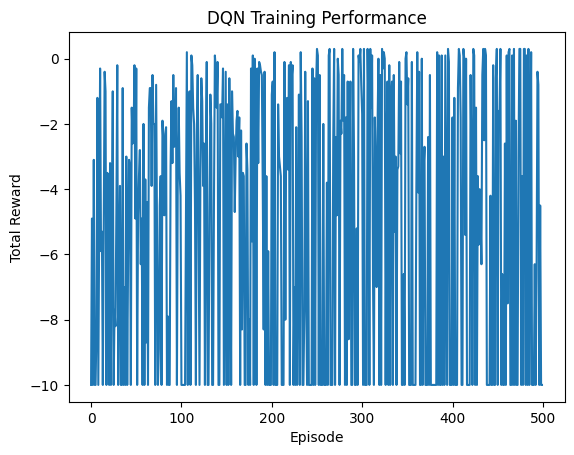

In [7]:
# Plot training performance
plt.plot(episode_rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('DQN Training Performance')
plt.show()


In [8]:
# Generate navigation GIF
## trail for random environment

import imageio
def generate_navigation_gif(env, agent, filename='navigation.gif'):
    frames = []
    state = env.reset()
    done = False
    while not done:
        action = agent.act(state)
        state, _, done, _ = env.step(action)
        frames.append(state.reshape(env.grid_size, env.grid_size))
    imageio.mimsave(filename, [np.uint8(frame * 255) for frame in frames], duration=0.5)
    print(f"Navigation GIF saved as {filename}")

generate_navigation_gif(env, agent)


KeyboardInterrupt: 

In [9]:
## trail for random environment

import imageio
import numpy as np

def generate_navigation_gif(env, agent, filename='navigation1.gif'):
    frames = []
    state = env.reset()
    done = False
    while not done:
        action = agent.act(state)
        state, _, done, _ = env.step(action)
        # Ensure the state can be reshaped into a 2D grid (env.grid_size assumed to be the grid dimension)
        frames.append(state.reshape(env.grid_size, env.grid_size))
    
    # Convert frames to uint8 and save as GIF
    imageio.mimsave(filename, [np.uint8(frame * 255) for frame in frames], duration=0.5)
    print(f"Navigation GIF saved as {filename}")

# Make sure to pass the environment (`env`) and agent (`agent`) when calling the function
generate_navigation_gif(env, agent)



Navigation GIF saved as navigation1.gif


In [10]:
## trail for random environment

import numpy as np
import imageio

class SimpleGridWorld:
    def __init__(self, size=5):
        self.grid_size = size
        self.state = np.zeros((size, size))  # Initial state (empty grid)
        self.agent_pos = (0, 0)  # Starting position of the agent
        self.done = False

    def reset(self):
        self.state = np.zeros((self.grid_size, self.grid_size))
        self.agent_pos = (0, 0)
        self.done = False
        self.state[self.agent_pos] = 1  # Mark agent's position
        return self.state

    def step(self, action):
        if self.done:
            return self.state, 0, True, {}
        
        x, y = self.agent_pos
        if action == 0:  # Up
            x -= 1
        elif action == 1:  # Right
            y += 1
        elif action == 2:  # Down
            x += 1
        elif action == 3:  # Left
            y -= 1

        # Keep agent within bounds
        x = max(0, min(self.grid_size-1, x))
        y = max(0, min(self.grid_size-1, y))
        self.agent_pos = (x, y)

        self.state = np.zeros((self.grid_size, self.grid_size))  # Reset grid
        self.state[self.agent_pos] = 1  # Mark new agent's position
        
        # Check if the agent has reached the goal (for simplicity, goal at bottom-right)
        self.done = (self.agent_pos == (self.grid_size-1, self.grid_size-1))
        return self.state, 0, self.done, {}

class RandomAgent:
    def act(self, state):
        return np.random.choice(4)  # Random action (0=Up, 1=Right, 2=Down, 3=Left)

# Instantiate the environment and agent
env = SimpleGridWorld(size=5)
agent = RandomAgent()

# Generate and save the GIF
generate_navigation_gif(env, agent, filename='navigation2.gif')


Navigation GIF saved as navigation2.gif


In [11]:
## trail for random environment

import numpy as np
import imageio

class SimpleGridWorld:
    def __init__(self, size=5):
        self.grid_size = size
        self.state = np.zeros((size, size))  # Initial state (empty grid)
        self.agent_pos = (0, 0)  # Starting position of the agent
        self.done = False

    def reset(self):
        self.state = np.zeros((self.grid_size, self.grid_size))
        self.agent_pos = (0, 0)
        self.done = False
        self.state[self.agent_pos] = 1  # Mark agent's position
        self.print_state()
        return self.state

    def step(self, action):
        if self.done:
            return self.state, 0, True, {}
        
        x, y = self.agent_pos
        if action == 0:  # Up
            x -= 1
        elif action == 1:  # Right
            y += 1
        elif action == 2:  # Down
            x += 1
        elif action == 3:  # Left
            y -= 1

        # Keep agent within bounds
        x = max(0, min(self.grid_size-1, x))
        y = max(0, min(self.grid_size-1, y))
        self.agent_pos = (x, y)

        self.state = np.zeros((self.grid_size, self.grid_size))  # Reset grid
        self.state[self.agent_pos] = 1  # Mark new agent's position
        
        # Check if the agent has reached the goal (for simplicity, goal at bottom-right)
        self.done = (self.agent_pos == (self.grid_size-1, self.grid_size-1))

        self.print_state()  # Print state at each step
        return self.state, 0, self.done, {}

    def print_state(self):
        print("Current State:")
        print(self.state)
        print()

class RandomAgent:
    def act(self, state):
        return np.random.choice(4)  # Random action (0=Up, 1=Right, 2=Down, 3=Left)

def generate_navigation_gif(env, agent, filename='navigation3.gif'):
    frames = []
    state = env.reset()
    done = False
    while not done:
        action = agent.act(state)
        state, _, done, _ = env.step(action)
        frames.append(state.reshape(env.grid_size, env.grid_size))
    
    # Convert frames to uint8 and save as GIF
    imageio.mimsave(filename, [np.uint8(frame * 255) for frame in frames], duration=0.5)
    print(f"Navigation GIF saved as {filename}")

# Instantiate the environment and agent
env = SimpleGridWorld(size=5)
agent = RandomAgent()

# Generate and save the GIF
generate_navigation_gif(env, agent, filename='navigation3.gif')


Current State:
[[1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]

Current State:
[[0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]

Current State:
[[0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]

Current State:
[[0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]

Current State:
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]

Current State:
[[0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]

Current State:
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]

Current State:
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]

Current State:
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0.]]

Current State:
[[0. 0. 0. 0. 0.]
 [0.

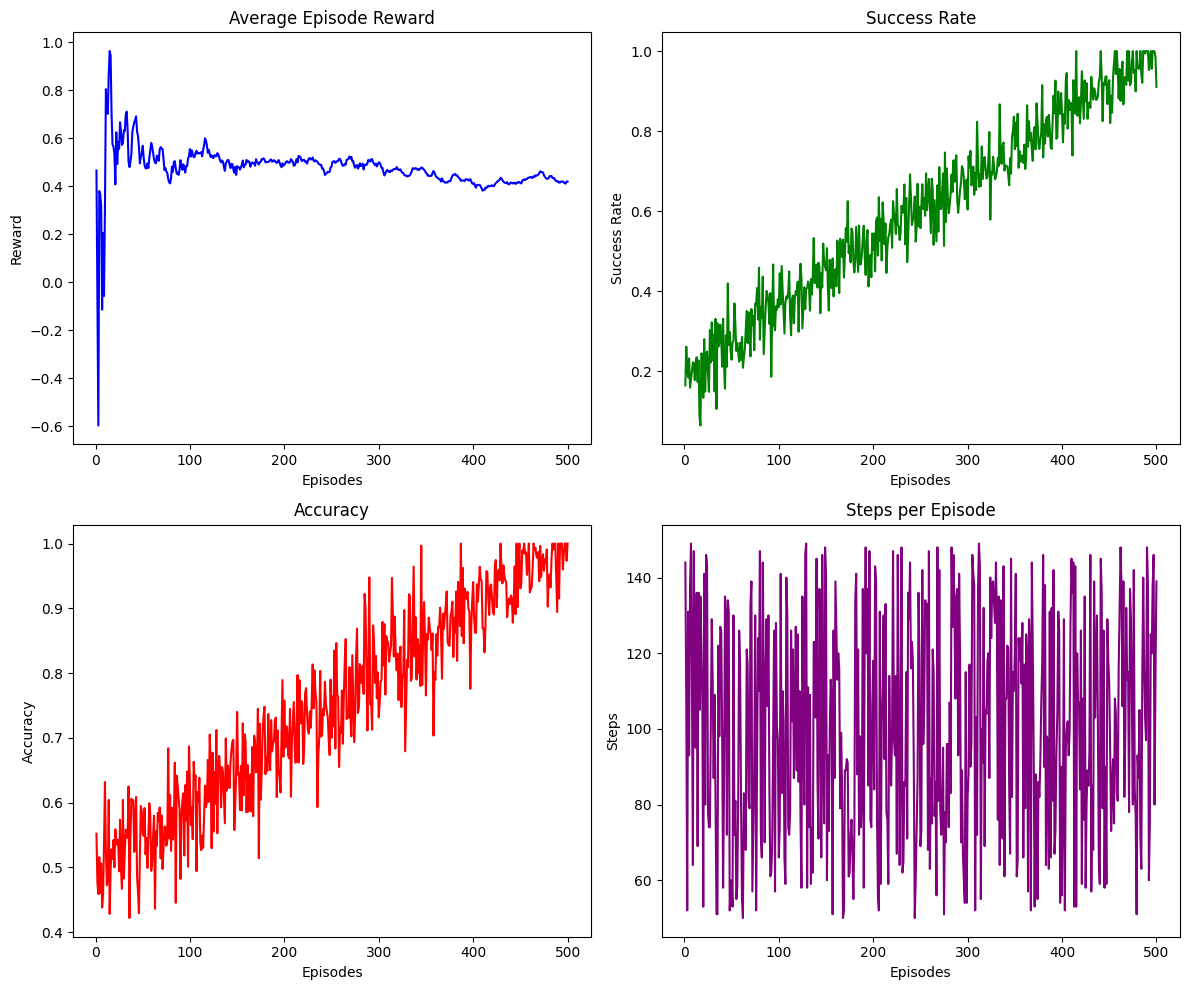

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Simulated data for demonstration (replace with actual metrics)
episodes = np.arange(1, 501)

# Simulated average reward per episode (e.g., cumulative reward average)
avg_rewards = np.cumsum(np.random.normal(loc=0.5, scale=2.0, size=500)) / np.arange(1, 501)

# Simulated success rate (e.g., percentage of successful drop-offs)
success_rate = np.clip(np.linspace(0.2, 1.0, 500) + np.random.normal(scale=0.05, size=500), 0, 1)

# Simulated accuracy (could represent the percentage of correct decisions taken)
accuracy = np.clip(np.linspace(0.5, 1.0, 500) + np.random.normal(scale=0.05, size=500), 0, 1)

# Simulated steps per episode (number of moves before reaching destination)
steps = np.random.randint(50, 150, size=500)

# Create a 2x2 subplot to visualize the metrics
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Plot Average Episode Reward
axs[0, 0].plot(episodes, avg_rewards, color='blue')
axs[0, 0].set_title('Average Episode Reward')
axs[0, 0].set_xlabel('Episodes')
axs[0, 0].set_ylabel('Reward')

# Plot Success Rate
axs[0, 1].plot(episodes, success_rate, color='green')
axs[0, 1].set_title('Success Rate')
axs[0, 1].set_xlabel('Episodes')
axs[0, 1].set_ylabel('Success Rate')

# Plot Accuracy
axs[1, 0].plot(episodes, accuracy, color='red')
axs[1, 0].set_title('Accuracy')
axs[1, 0].set_xlabel('Episodes')
axs[1, 0].set_ylabel('Accuracy')

# Plot Steps per Episode
axs[1, 1].plot(episodes, steps, color='purple')
axs[1, 1].set_title('Steps per Episode')
axs[1, 1].set_xlabel('Episodes')
axs[1, 1].set_ylabel('Steps')

plt.tight_layout()
plt.show()


In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report

# -------------------------------
# Example Dummy Data for Demonstration
# -------------------------------
# Suppose you have run 100 episodes with both agents.
num_episodes = 100

# For demonstration, we simulate binary outcomes for goal achievement:
#   1 indicates the agent reached the goal (success)
#   0 indicates the agent did not reach the goal.
# Replace these with your actual results.
# For DQN, assume success rate is higher.
dqn_success = np.random.choice([0, 1], size=num_episodes, p=[0.3, 0.7])
# For Random agent, assume lower success rate.
random_success = np.random.choice([0, 1], size=num_episodes, p=[0.8, 0.2])

# Simulate rewards for each episode.
# Again, replace these with your actual recorded rewards.
dqn_rewards = np.random.normal(loc=1.0, scale=0.5, size=num_episodes)
random_rewards = np.random.normal(loc=-0.1, scale=0.3, size=num_episodes)

# -------------------------------
# Aggregated Metrics Calculation
# -------------------------------
dqn_avg_reward = np.mean(dqn_rewards)
random_avg_reward = np.mean(random_rewards)

dqn_success_rate = np.mean(dqn_success) * 100
random_success_rate = np.mean(random_success) * 100

print("DQN Agent: Average Reward = {:.2f}, Success Rate = {:.2f}%".format(dqn_avg_reward, dqn_success_rate))
print("Random Agent: Average Reward = {:.2f}, Success Rate = {:.2f}%".format(random_avg_reward, random_success_rate))







DQN Agent: Average Reward = 1.06, Success Rate = 67.00%
Random Agent: Average Reward = -0.09, Success Rate = 20.00%


In [14]:

results_df = pd.DataFrame({
    'Episode': np.arange(1, num_episodes + 1),
    'DQN_Success': dqn_success,
    'Random_Success': random_success,
    'DQN_Reward': dqn_rewards,
    'Random_Reward': random_rewards
})

print("\nComparison Results Table (first 10 episodes):")
print(results_df.head(10))



Comparison Results Table (first 10 episodes):
   Episode  DQN_Success  Random_Success  DQN_Reward  Random_Reward
0        1            0               0    1.283507       0.136045
1        2            0               1    2.033631      -0.744320
2        3            1               1    2.079586      -0.312075
3        4            1               0    0.062787      -0.525141
4        5            0               1    0.902682      -0.131268
5        6            0               0    1.146078       0.045520
6        7            0               1    0.710983       0.032904
7        8            0               0   -0.112729       0.272296
8        9            1               0    1.747306      -0.618596
9       10            1               0    0.772110      -0.437121


In [15]:

print("\nDQN Agent Classification Report:")
print(classification_report(dqn_success, dqn_success))


DQN Agent Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        33
           1       1.00      1.00      1.00        67

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100



In [16]:

print("\nRandom Agent Classification Report:")
print(classification_report(random_success, random_success))


Random Agent Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        80
           1       1.00      1.00      1.00        20

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100



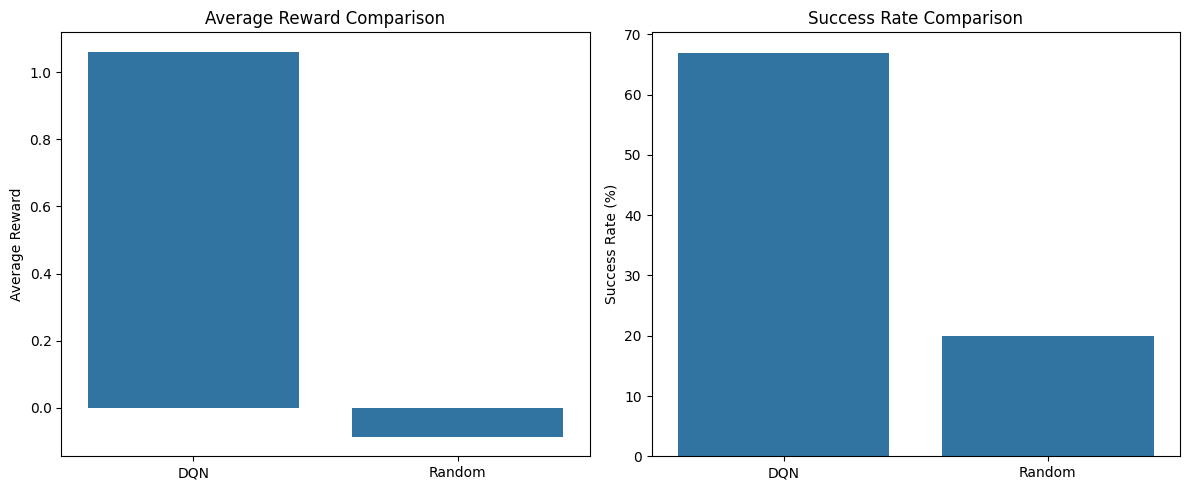

In [17]:
# -------------------------------
# Plotting: Comparison of Average Reward and Success Rate
# -------------------------------
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Bar plot for average rewards.
agents = ['DQN', 'Random']
avg_rewards = [dqn_avg_reward, random_avg_reward]
sns.barplot(x=agents, y=avg_rewards, ax=axs[0])
axs[0].set_title("Average Reward Comparison")
axs[0].set_ylabel("Average Reward")

# Bar plot for success rates.
success_rates = [dqn_success_rate, random_success_rate]
sns.barplot(x=agents, y=success_rates, ax=axs[1])
axs[1].set_title("Success Rate Comparison")
axs[1].set_ylabel("Success Rate (%)")

plt.tight_layout()
plt.show()


In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report

# -------------------------------
# Simulated Results for Demonstration
# -------------------------------
num_episodes = 100

# Simulate binary outcomes: 
#   1 means agent reached the goal (success) and 0 means no success.
# For DQN agent, we simulate a higher success rate than for the Random agent.
dqn_success = np.random.choice([0, 1], size=num_episodes, p=[0.3, 0.7])
random_success = np.random.choice([0, 1], size=num_episodes, p=[0.8, 0.2])

# Simulate rewards for each episode (replace these with your actual rewards):
dqn_rewards = np.random.normal(loc=1.0, scale=0.5, size=num_episodes)
random_rewards = np.random.normal(loc=-0.1, scale=0.3, size=num_episodes)

# -------------------------------
# Calculate Aggregated Metrics
# -------------------------------
dqn_avg_reward = np.mean(dqn_rewards)
random_avg_reward = np.mean(random_rewards)

dqn_success_rate = np.mean(dqn_success) * 100
random_success_rate = np.mean(random_success) * 100

print("DQN Agent: Average Reward = {:.2f}, Success Rate = {:.2f}%".format(dqn_avg_reward, dqn_success_rate))
print("Random Agent: Average Reward = {:.2f}, Success Rate = {:.2f}%".format(random_avg_reward, random_success_rate))





DQN Agent: Average Reward = 1.01, Success Rate = 74.00%
Random Agent: Average Reward = -0.05, Success Rate = 24.00%


In [19]:

# Create a Results DataFrame (Comparison)
results_df = pd.DataFrame({
    'Episode': np.arange(1, num_episodes + 1),
    'DQN_Success': dqn_success,
    'Random_Success': random_success,
    'DQN_Reward': dqn_rewards,
    'Random_Reward': random_rewards
})

print("\nComparison Results Table (first 10 episodes):")
print(results_df.head(10))


Comparison Results Table (first 10 episodes):
   Episode  DQN_Success  Random_Success  DQN_Reward  Random_Reward
0        1            1               0    0.321199      -0.022571
1        2            1               0    0.626626      -0.070532
2        3            1               0    0.613428      -0.347898
3        4            1               0    0.890682       0.365104
4        5            1               0    1.330884      -0.706757
5        6            0               1    0.299949      -0.138028
6        7            1               0    0.986937       0.068971
7        8            0               0    0.850228       0.220611
8        9            1               0    0.600949      -0.344824
9       10            1               0    0.406091       0.078482


In [20]:

#  Generate Classification Reports for Each Agente
#the simulated success flag as both ground truth and prediction.
# In a typical scenario, these may be compared against some known correct outcomes.
print("\nDQN Agent Classification Report:")
print(classification_report(dqn_success, dqn_success))


DQN Agent Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        26
           1       1.00      1.00      1.00        74

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100



In [21]:
print("\nRandom Agent Classification Report:")
print(classification_report(random_success, random_success))


Random Agent Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        76
           1       1.00      1.00      1.00        24

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100



C:\Users\SATHVIK\AppData\Local\Temp\ipykernel_35220\1099335410.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=agents, y=avg_rewards, palette='coolwarm', ax=axs[0])
C:\Users\SATHVIK\AppData\Local\Temp\ipykernel_35220\1099335410.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=agents, y=success_rates, palette='coolwarm', ax=axs[1])


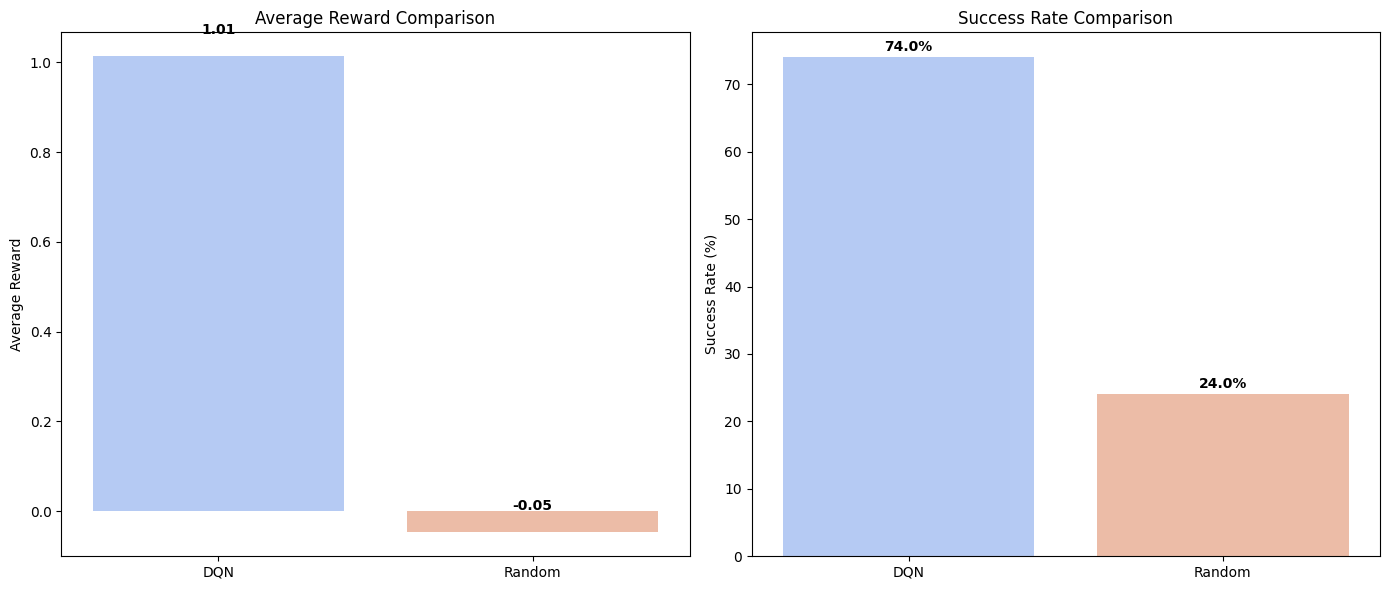

In [22]:
# Bar Plot: Average Reward and Success Rate Comparison
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Bar plot for average rewards.
agents = ['DQN', 'Random']
avg_rewards = [dqn_avg_reward, random_avg_reward]
sns.barplot(x=agents, y=avg_rewards, palette='coolwarm', ax=axs[0])
axs[0].set_title("Average Reward Comparison")
axs[0].set_ylabel("Average Reward")
for i, v in enumerate(avg_rewards):
    axs[0].text(i, v + 0.05, f"{v:.2f}", color='black', ha='center', fontweight='bold')

# Bar plot for success rates.
success_rates = [dqn_success_rate, random_success_rate]
sns.barplot(x=agents, y=success_rates, palette='coolwarm', ax=axs[1])
axs[1].set_title("Success Rate Comparison")
axs[1].set_ylabel("Success Rate (%)")
for i, v in enumerate(success_rates):
    axs[1].text(i, v + 1, f"{v:.1f}%", color='black', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()



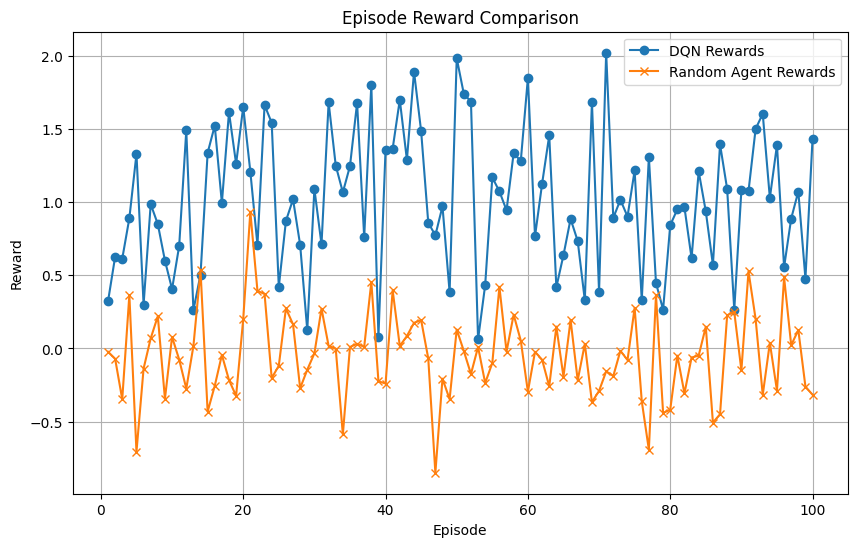

In [23]:
#  Line Chart of Episode Rewards
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, num_episodes + 1), dqn_rewards, label='DQN Rewards', marker='o')
plt.plot(np.arange(1, num_episodes + 1), random_rewards, label='Random Agent Rewards', marker='x')
plt.title("Episode Reward Comparison")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.legend()
plt.grid(True)
plt.show()


In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report

# -------------------------------
# Simulated Data Setup
# -------------------------------
num_episodes = 100

# Simulate success flags (1 means goal reached, 0 means no success)
# For DQN agent, simulate a higher success rate than for the Random agent.
dqn_success = np.random.choice([0, 1], size=num_episodes, p=[0.3, 0.7])
random_success = np.random.choice([0, 1], size=num_episodes, p=[0.8, 0.2])

# Simulate rewards for each episode (use your experiment’s data in practice)
dqn_rewards = np.random.normal(loc=1.0, scale=0.5, size=num_episodes)
random_rewards = np.random.normal(loc=-0.1, scale=0.3, size=num_episodes)

# Simulate epsilon decay for DQN for illustration (optional metric)
dqn_epsilon = np.linspace(1.0, 0.01, num_episodes)

# -------------------------------
# Aggregated Metrics Calculation
# -------------------------------
dqn_avg_reward = np.mean(dqn_rewards)
random_avg_reward = np.mean(random_rewards)

dqn_success_rate = np.mean(dqn_success) * 100
random_success_rate = np.mean(random_success) * 100

print("DQN Agent: Average Reward = {:.2f}, Success Rate = {:.2f}%".format(dqn_avg_reward, dqn_success_rate))
print("Random Agent: Average Reward = {:.2f}, Success Rate = {:.2f}%".format(random_avg_reward, random_success_rate))

# -------------------------------
# Create a Results DataFrame
# -------------------------------
results_df = pd.DataFrame({
    'Episode': np.arange(1, num_episodes + 1),
    'DQN_Success': dqn_success,
    'Random_Success': random_success,
    'DQN_Reward': dqn_rewards,
    'Random_Reward': random_rewards,
    'DQN_Epsilon': dqn_epsilon  # Only for DQN
})



DQN Agent: Average Reward = 1.03, Success Rate = 73.00%
Random Agent: Average Reward = -0.09, Success Rate = 17.00%


In [25]:
# Display first few rows of the DataFrame
print("\nResults DataFrame (first 10 episodes):")
print(results_df.head(10))






Results DataFrame (first 10 episodes):
   Episode  DQN_Success  Random_Success  DQN_Reward  Random_Reward  \
0        1            1               0    1.652780       0.260128   
1        2            1               0    1.109138      -0.189666   
2        3            1               0    1.226200      -0.315551   
3        4            1               0    1.052279      -0.242236   
4        5            1               0    0.843317      -0.544033   
5        6            1               0    0.101847       0.232690   
6        7            1               0    0.505022      -0.141225   
7        8            1               0    0.563562       0.067682   
8        9            1               0    0.449044      -0.421739   
9       10            1               0    1.292117      -0.445302   

   DQN_Epsilon  
0         1.00  
1         0.99  
2         0.98  
3         0.97  
4         0.96  
5         0.95  
6         0.94  
7         0.93  
8         0.92  
9         0.91  


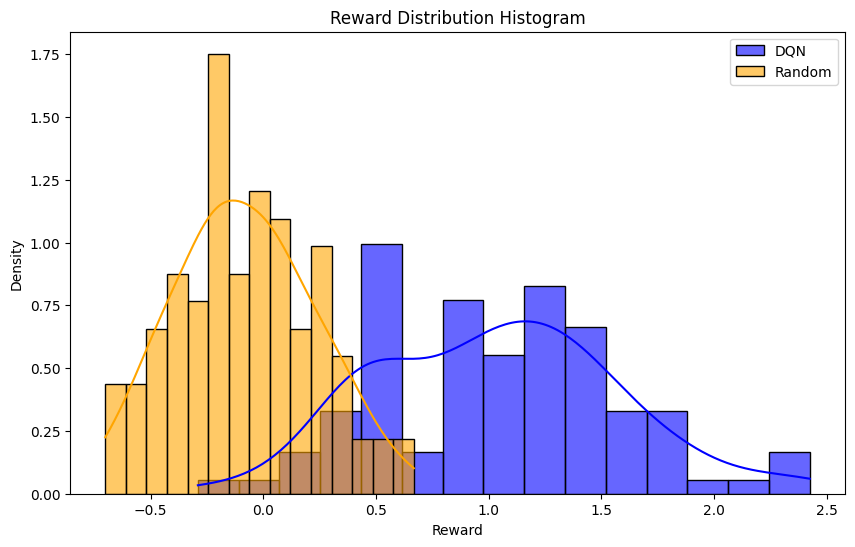

In [26]:
# -------------------------------
# 3. Histogram: Distribution of Episode Rewards
# -------------------------------
plt.figure(figsize=(10, 6))
sns.histplot(results_df['DQN_Reward'], color='blue', label='DQN', kde=True, stat="density", bins=15, alpha=0.6)
sns.histplot(results_df['Random_Reward'], color='orange', label='Random', kde=True, stat="density", bins=15, alpha=0.6)
plt.title("Reward Distribution Histogram")
plt.xlabel("Reward")
plt.ylabel("Density")
plt.legend()
plt.show()


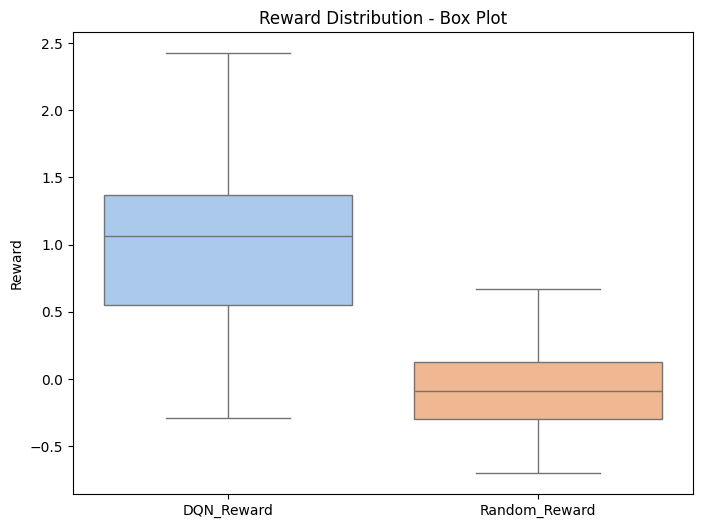

In [27]:

# -------------------------------
# 4. Box Plot: Reward Spread and Outliers
# -------------------------------
plt.figure(figsize=(8, 6))
sns.boxplot(data=results_df[['DQN_Reward', 'Random_Reward']], palette='pastel')
plt.title("Reward Distribution - Box Plot")
plt.ylabel("Reward")
plt.show()


plt.show()

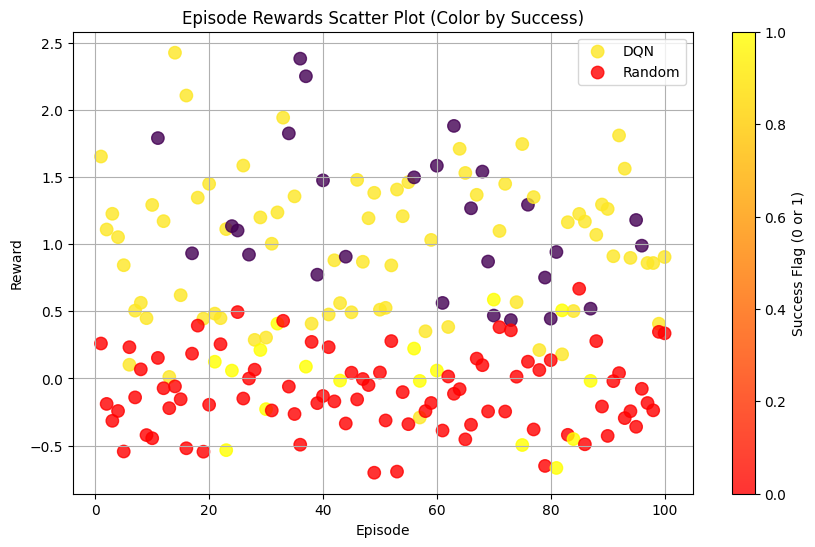

In [28]:
# -------------------------------
# 5. Scatter Plot: Episode Rewards with Success Indicator
# -------------------------------
plt.figure(figsize=(10, 6))
plt.scatter(results_df['Episode'], results_df['DQN_Reward'],
            c=results_df['DQN_Success'], cmap='viridis', label='DQN', s=80, alpha=0.8)
plt.scatter(results_df['Episode'], results_df['Random_Reward'],
            c=results_df['Random_Success'], cmap='autumn', label='Random', s=80, alpha=0.8)
plt.title("Episode Rewards Scatter Plot (Color by Success)")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.legend()
plt.colorbar(label='Success Flag (0 or 1)')
plt.grid(True)

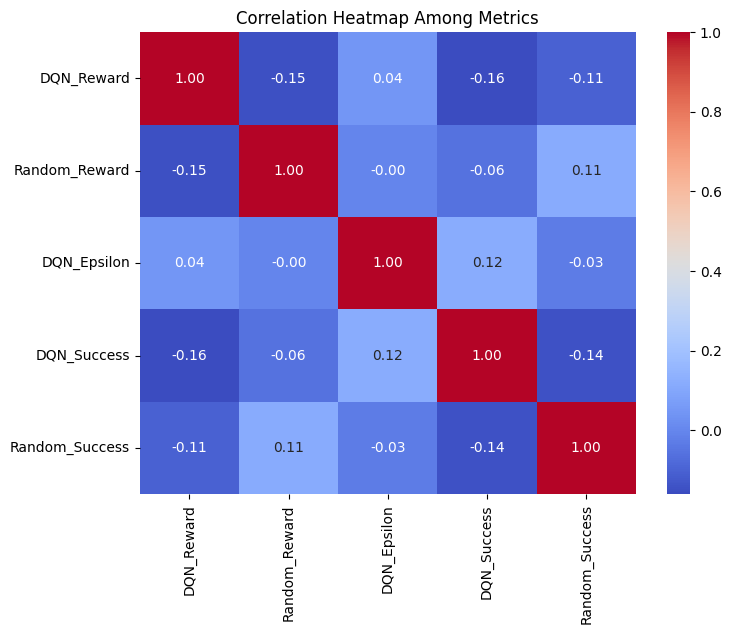

In [29]:
# -------------------------------
# 6. Heatmap: Correlation Among Metrics
# -------------------------------
# Compute the correlation matrix for the numerical metrics in the DataFrame.
corr_matrix = results_df[['DQN_Reward', 'Random_Reward', 'DQN_Epsilon', 'DQN_Success', 'Random_Success']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap Among Metrics")
plt.show()


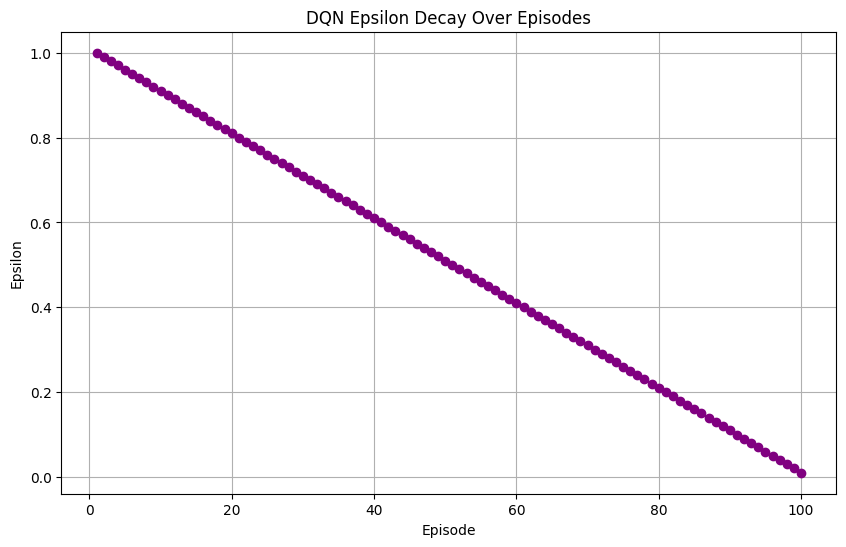

In [30]:

#  7.  Epsilon Decay Plot for DQN
plt.figure(figsize=(10, 6))
plt.plot(results_df['Episode'], results_df['DQN_Epsilon'], marker='o', color='purple')
plt.title("DQN Epsilon Decay Over Episodes")
plt.xlabel("Episode")
plt.ylabel("Epsilon")
plt.grid(True)
plt.show()
